# OceanParcels
## Run Model

In [2]:
import xarray as xr
import pandas as pd
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import datetime
from operator import attrgetter
from matplotlib import pyplot as plt

In [5]:
df = xr.open_mfdataset('../../../data/Hycom/*.nc',decode_times=False)# all of our HYCOM data
dfGrid = pd.read_pickle('processingFiles/dfS1Grid.pkl') # the grid from the first large scale survey which we will use as seeding points

In [6]:
# If a particle goes "out of bounds", delete it instead of stopping the code
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    

# Create a particle that can measure the distance it has gone instead of just counting lats/lons
class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    
def TotalDistance(particle, fieldset, time):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat
    
    
def myround(x, base=3):
    return base * round(x/base)

Edit the box below for the parameters (depth, filename, run days, interval) and run.

In [9]:
outputFileNamePrefix = 'processingFiles/60Day3Hour40MeterAll'  # Set the name for the files
lons = dfGrid.lonC.values+360   # Set the lon for grid
lats = dfGrid.latC.values               # Set the lat for grid
mDepth = np.copy(lons)
mDepth[:] = 40                              # Set the depth to model

filenames = {'U': df,
             'V': df}
variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time',
             'depth': 'depth'}

fieldset = FieldSet.from_xarray_dataset(df, variables, dimensions,allow_time_extrapolation=True)
pset = ParticleSet(fieldset=fieldset, pclass=DistParticle,lon=lons,lat=lats, depth = mDepth)
k_dist = pset.Kernel(TotalDistance)
pset.execute(AdvectionRK4 + k_dist,
             runtime=datetime.timedelta(days=60),   # SET DAYS
             dt=datetime.timedelta(hours=3),        # SET HOURS
             output_file=pset.ParticleFile(name=outputFileNamePrefix+".nc", 
             outputdt=datetime.timedelta(hours=3)),recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled DistParticleAdvectionRK4TotalDistance ==> C:\Users\Robert\AppData\Local\Temp\parcels-tmp\d6cfef8ecf230b30a7185de82076706f_0.dll
INFO: Temporary output files are stored in out-SCBTHKVN.
INFO: You can use "parcels_convert_npydir_to_netcdf out-SCBTHKVN" to convert these to a NetCDF file during the run.
100% (5184000.0 of 5184000.0) |##########| Elapsed Time: 1:25:58 Time:  1:25:58


# Clean the datasets

In [6]:
def cleanTraj(df):
    gTime, gLat, gLon = [[] for i in range(3)]
    for i in range(len(df.lat)):
        if (len(np.unique(df.lon[i])) <len(df.lon[i])*.8) & (len(np.unique(df.lat[i])) < len(df.lat[i])*.8):
            continue
        else:
            gTime.append(df.time[i])
            gLat.append(df.lat[i])
            gLon.append(df.lon[i])
    ds = xr.Dataset({'time':(('traj','obs'), gTime), 'lat':(('traj','obs'),gLat), 'lon':(('traj','obs'),gLon)})
    return ds

pds10 = xr.open_dataset("processingFiles/60Day3Hour10MeterAll.nc", decode_times=False)
pds10clean = cleanTraj(pds10)
pds10clean.to_netcdf('processingFiles/60Day3Hour10MeterAll_clean.nc')
pds20 = xr.open_dataset("processingFiles/60Day3Hour20MeterAll.nc", decode_times=False)
pds20clean = cleanTraj(pds20)
pds20clean.to_netcdf('processingFiles/60Day3Hour20MeterAll_clean.nc')
pds30 = xr.open_dataset("processingFiles/60Day3Hour30MeterAll.nc", decode_times=False)
pds30clean = cleanTraj(pds30)
pds30clean.to_netcdf('processingFiles/60Day3Hour30MeterAll_clean.nc')
pds40 = xr.open_dataset("processingFiles/60Day3Hour40MeterAll.nc", decode_times=False)
pds40clean = cleanTraj(pds30)
pds40clean.to_netcdf('processingFiles/60Day3Hour40MeterAll_clean.nc')

# Plots
## Time series

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib.patches import Rectangle
from matplotlib import rcParams
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def fishDens(NASC, TS):
    dens = NASC/(4*np.pi*(10**(TS/10)))
    dens = dens*(1/3429904) # convers from nmi2 to m2
    return round(dens,3)

def fishTraj(df,dfGrid):
    locs, gTime, gLat, gLon = [[] for i in range(4)]
    for i in range(len(dfGrid.latC)):
        locs.append([dfGrid.latC.values[i],dfGrid.lonC.values[i]])
    gTime, gLat, gLon = [[] for i in range(3)]
    for i in range(len(df.lat)):
        if [float(df.lat[i][0]),float(df.lon[i][0])] in locs:
            gTime.append(df.time[i])
            gLat.append(df.lat[i])
            gLon.append(df.lon[i])
    ds = xr.Dataset({'time':(('traj','obs'), gTime), 'lat':(('traj','obs'),gLat), 'lon':(('traj','obs'),gLon)})
    return ds

0.1
96  out of  98


C:\Users\Robert\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


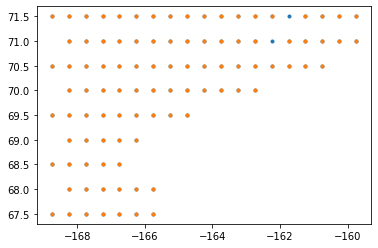

In [3]:
# Identify the grid cells with sA correspoinding with >.1 fish per m2
dfGrid = pd.read_pickle('processingFiles/dfS1Grid.pkl')
sa = 9.3  # the sA to get to .1 using the TS in the next line
print(fishDens(sa,-56.68)) # the mean target strength of the 1st survey
plt.plot(dfGrid.lonC,dfGrid.latC,'.')
plt.plot(dfGrid[dfGrid.nasc > sa].lonC,dfGrid[dfGrid.nasc > sa].latC,'.')
dfGridFish = dfGrid[dfGrid.nasc > sa] # make a new df of only the good points
dfGridFish.lonC = dfGridFish.lonC+360
print(len(dfGridFish),' out of ', len(dfGrid.nasc))

In [4]:
pds10 = xr.open_dataset("processingFiles/60Day3Hour10MeterAll_clean.nc", decode_times=False)
pds20 = xr.open_dataset("processingFiles/60Day3Hour20MeterAll_clean.nc", decode_times=False)
pds30 = xr.open_dataset("processingFiles/60Day3Hour30MeterAll_clean.nc", decode_times=False)
pds40 = xr.open_dataset("processingFiles/60Day3Hour40MeterAll_clean.nc", decode_times=False)

In [50]:
pds30 = xr.open_dataset("processingFiles/60Day3Hour30MeterAll_clean.nc", decode_times=False)
pds30_o = xr.open_dataset("60Day3Hour30MeterAll_clean.nc", decode_times=False)

## endlat = []
endlon = []
for lats in pds30.lat:
    endlat.append(lats[-11])
for lons in pds30.lon:
    endlon.append(lons[-11])
    
endlat2 = []
endlon2 = []
for lats in pds30_o.lat:
    endlat2.append(lats[-11])
for lons in pds30_o.lon:
    endlon2.append(lons[-11])
sum([a - b for a, b in zip(endlon, endlon2)])

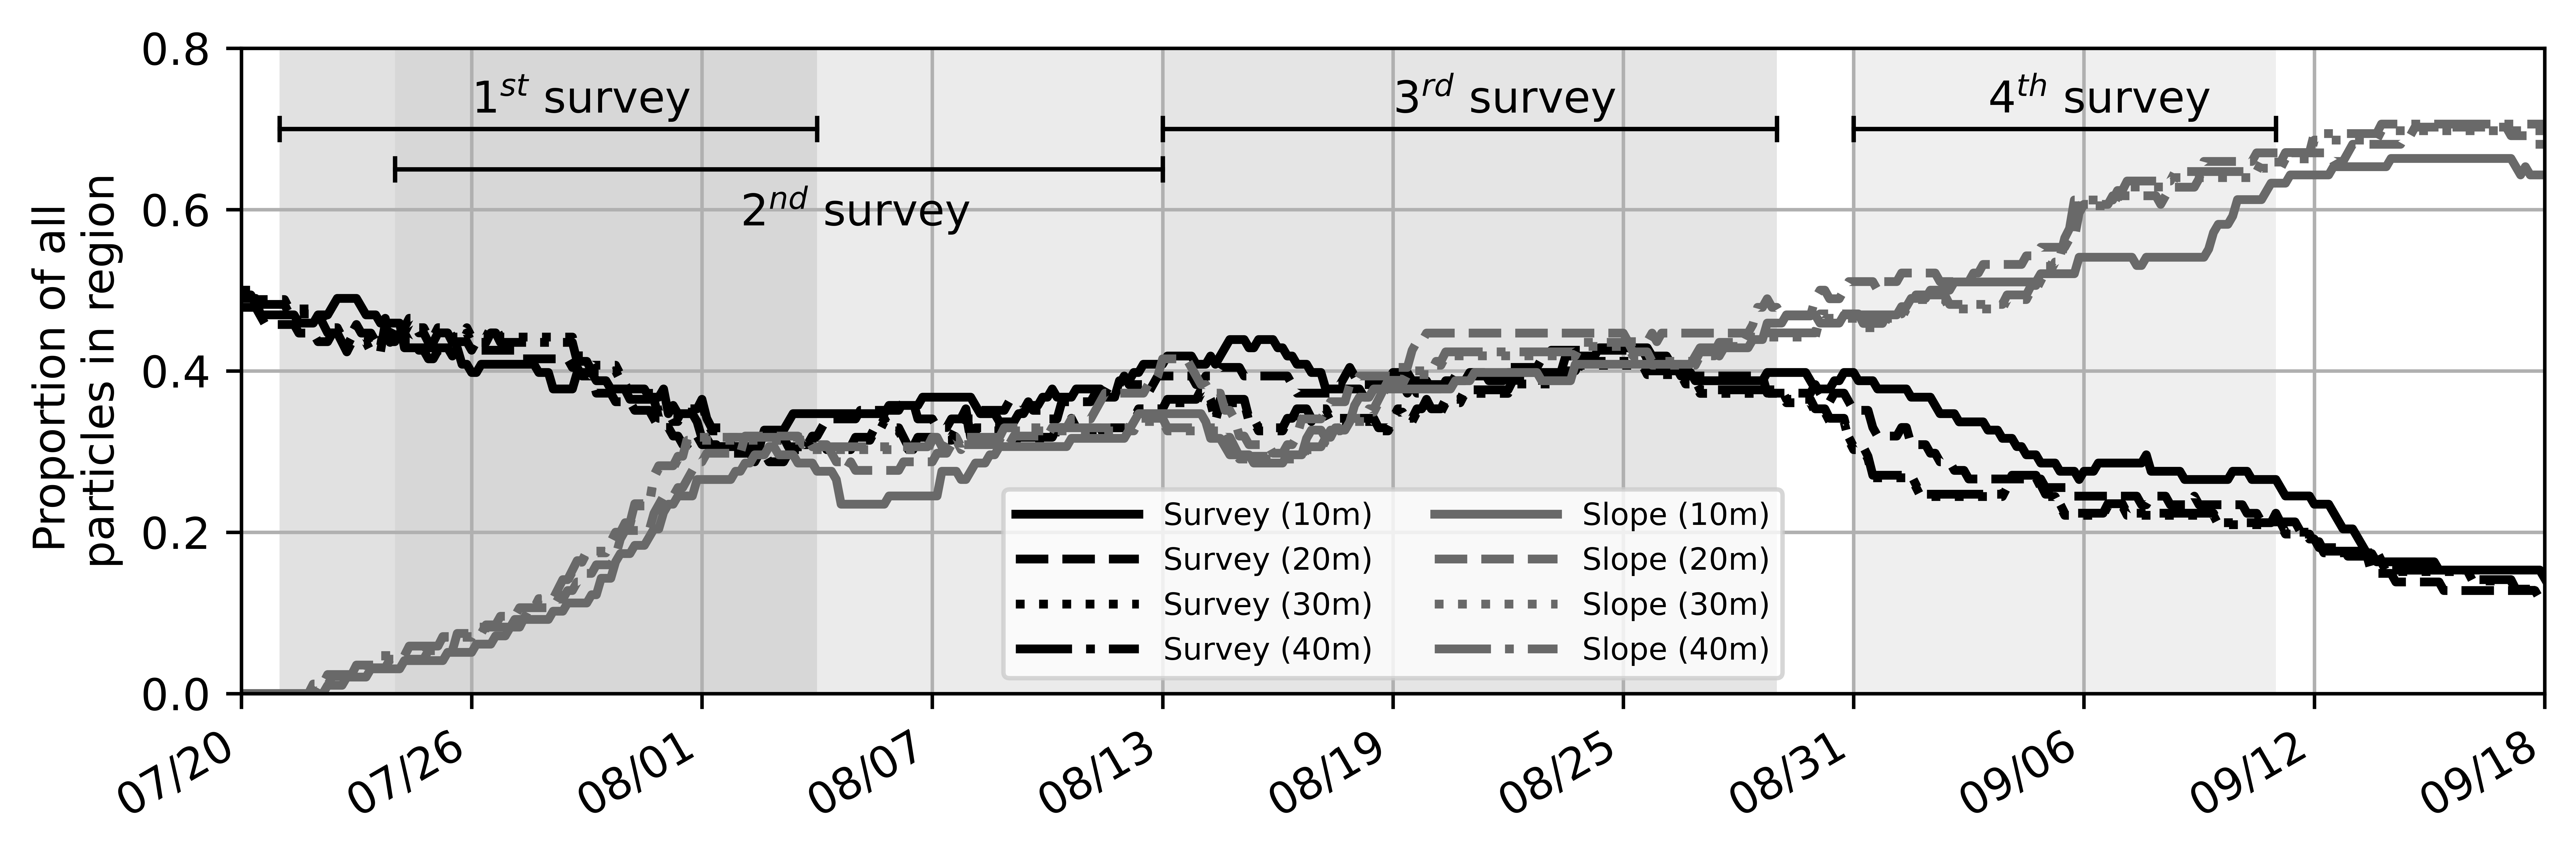

In [10]:
#FIGURE 7
start = datetime.datetime(2018,7,20,0,0,0)
pdsDates = []
for i in range(len(pds10.time[0])):
    pdsDates.append(start+datetime.timedelta(seconds=float(pds10.time[0,i].values)))
inBox10 = []
inBox20 = []
inBox30 = []
inBox40 = []
offShelf10 = []
offShelf20 = []
offShelf30 = []
offShelf40 = []
for i in range(len(pds10.obs)):
    inBox10.append(float(np.sum((pds10.lat[:,i] <=71.25) & (pds10.lat[:,i] >=69.25).values &(pds10.lon[:,i] <=198).values)))
    offShelf10.append(float(np.sum((pds10.lat[:,i] >=70) & (pds10.lon[:,i] >=203.211).values)) + 
                     float(np.sum((pds10.lat[:,i] >=72) & (pds10.lon[:,i] <=203.211).values)))
    inBox20.append(float(np.sum((pds20.lat[:,i] <=71.25) & (pds20.lat[:,i] >=69.25).values &(pds20.lon[:,i] <=198).values)))
    offShelf20.append(float(np.sum((pds20.lat[:,i] >=70) & (pds20.lon[:,i] >=203.211).values)) + 
                     float(np.sum((pds20.lat[:,i] >=72) & (pds20.lon[:,i] <=203.211).values)))
    inBox30.append(float(np.sum((pds30.lat[:,i] <=71.25) & (pds30.lat[:,i] >=69.25).values &(pds30.lon[:,i] <=198).values)))
    offShelf30.append(float(np.sum((pds30.lat[:,i] >=70) & (pds30.lon[:,i] >=203.211).values)) + 
                     float(np.sum((pds30.lat[:,i] >=72) & (pds30.lon[:,i] <=203.211).values)))
    inBox40.append(float(np.sum((pds40.lat[:,i] <=71.25) & (pds40.lat[:,i] >=69.25).values &(pds40.lon[:,i] <=198).values)))
    offShelf40.append(float(np.sum((pds40.lat[:,i] >=70) & (pds40.lon[:,i] >=203.211).values)) + 
                     float(np.sum((pds40.lat[:,i] >=72) & (pds40.lon[:,i] <=203.211).values)))
fig = plt.figure(figsize=(9.4,3),dpi=1200)
rcParams['lines.linewidth'] = 2
rcParams['font.size']=10
ax1 = plt.subplot(111)


# proportion of all particles in box
ax1.plot(pdsDates,[(x)/(len(pds10.traj)) for x in inBox10],'-k')
ax1.plot(pdsDates,[(x)/(len(pds20.traj)) for x in inBox20],'--k')
ax1.plot(pdsDates,[(x)/(len(pds30.traj)) for x in inBox30],':k')
ax1.plot(pdsDates,[(x)/(len(pds40.traj)) for x in inBox40],'-.k')


#proportion of all particles off shelf
ax1.plot(pdsDates,[x/(len(pds10.traj)) for x in offShelf10],'-',color='dimgray')
ax1.plot(pdsDates,[x/(len(pds20.traj)) for x in offShelf20],'--',color='dimgray')
ax1.plot(pdsDates,[x/(len(pds30.traj)) for x in offShelf30],':',color='dimgray')
ax1.plot(pdsDates,[x/(len(pds40.traj)) for x in offShelf40],'-.',color='dimgray')


ax1.set_ylim([0,.8])
ax1.text(pdsDates[8]+datetime.timedelta(days=5),.72,'1$^{st}$ survey')
ax1.text(pdsDates[32]+datetime.timedelta(days=9),.58,'2$^{nd}$ survey')
ax1.text(pdsDates[192]+datetime.timedelta(days=6),.72,'3$^{rd}$ survey')
ax1.text(pdsDates[336]+datetime.timedelta(days=3.5),.72,'4$^{th}$ survey')
# Add the boxes for the surveys
rect =Rectangle((pdsDates[8],0),datetime.timedelta(days=14),1,edgecolor='None',facecolor="dimgray", alpha=0.2)
ax1.add_patch(rect)
rect =Rectangle((pdsDates[32],0),datetime.timedelta(days=20),1,edgecolor='None',facecolor="silver",alpha=0.3)
ax1.add_patch(rect)
rect =Rectangle((pdsDates[192],0),datetime.timedelta(days=16),1,edgecolor='None',facecolor="gray",alpha=0.2)
ax1.add_patch(rect)
rect =Rectangle((pdsDates[336],0),datetime.timedelta(days=11),1,edgecolor='None',facecolor="lightgray",alpha=0.35)
ax1.add_patch(rect)
ax1.set_ylabel('Proportion of all \nparticles in region')

ax1.plot([pdsDates[8],pdsDates[8]+datetime.timedelta(days=14)],[.7,.7],color='k',linewidth=1,marker='|')
ax1.plot([pdsDates[32],pdsDates[32]+datetime.timedelta(days=20)],[.65,.65],color='k',linewidth=1,marker='|')
ax1.plot([pdsDates[192],pdsDates[192]+datetime.timedelta(days=16)],[.7,.7],color='k',linewidth=1,marker='|')
ax1.plot([pdsDates[336],pdsDates[336]+datetime.timedelta(days=11)],[.7,.7],color='k',linewidth=1,marker='|')
    
    
ax1.set_xlim([pdsDates[0],pdsDates[-1]])
ax1.legend(['Survey (10m)','Survey (20m)','Survey (30m)','Survey (40m)', 'Slope (10m)','Slope (20m)','Slope (30m)','Slope (40m)'],handlelength =4,prop={'size': 7},ncol=2,loc=8)
ax1.xaxis.set_ticks(np.append(np.arange(pdsDates[0], pdsDates[-1], datetime.timedelta(days=6)),pdsDates[-1]))
fig.autofmt_xdate()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.grid()
#plt.savefig("G:/My Drive/Research/Arctic EIS II/Saildrone/manuscript/Final/figsUnfiltered/Submitted/svg/F7_1.svg")

## Create the Maps

In [28]:
from matplotlib import rcParams
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Read in and setup the TOPO data
etopo1name = 'processingFiles/etopo1_bedrock.asc'
topo_file = open(etopo1name, 'r')
ncols = int(topo_file.readline().split()[1])
nrows = int(topo_file.readline().split()[1])
xllcorner = float(topo_file.readline().split()[1])
yllcorner = float(topo_file.readline().split()[1])
cellsize = float(topo_file.readline().split()[1])
topo_file.close()
dres = 1
etopo = np.loadtxt(etopo1name, skiprows=5)
etopo[:nrows+1, :] = etopo[nrows+1::-1, :]
etopo = etopo[::dres, ::dres]

# Create longitude and latitude vectors for etopo
clons = np.arange(xllcorner, xllcorner+cellsize*ncols, cellsize)[::dres]
clats = np.arange(yllcorner, yllcorner+cellsize*nrows, cellsize)[::dres]

etopo = etopo[(clats[:-1] >66)&(clats[:-1] <74)]
clats = clats[(clats >66)&(clats <74)]

# Draw etopo1, first for land and then for the ocean, with different colormaps
llevels = np.arange(-500,2251,100) # check etopo.ravel().max()
#lcs = m.contourf(rlons, rlats, etopo, llevels, cmap=cm.terrain)
olevels1 = [-1000,-100,-40]# change from NOAA int sugg
#olevels1 = [-500,-400,-300,-200,-100,-40]# change from NOAA int sugg
#olevels2 = [-5000,-4000,-3000,-2000,-1000] # change from NOAA int sugg
olevels3 = [0,10000]
olevels4 = [0]
rlons, rlats = (np.meshgrid(clons[:-1],clats))
rcParams['contour.negative_linestyle'] = 'solid'

In [29]:
# Create the map panels
pds = pds20
fig = plt.figure(figsize=(16,8),dpi=1200)
rcParams['lines.linewidth'] = .5
ax1 = plt.subplot(2,4,1,projection=ccrs.Mercator())
ax1.scatter(pds.lon[:,119], pds.lat[:,119],6,'deepskyblue',transform=ccrs.Geodetic(),zorder=4)
ax1.scatter(pds.lon[:,8], pds.lat[:,8],6,'darkblue',transform=ccrs.Geodetic(),zorder=4)
#ax1.add_feature(feature.LAND,zorder=3)
#ax1.coastlines(resolution='10m',zorder=4)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
gl.ylocator = mticker.FixedLocator([64,65,66,67,68,69,70,71,72,73,74])
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([190,210,67,73.5])
rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
# Add the patch to the Axes
ax1.add_patch(rect)
plt.title('1$^{st}$ survey (model start)\n'+ pdsDates[8].strftime("%B %d") + ' - '+pdsDates[119].strftime("%B %d, %Y"))
lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
#cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)


ax1 = plt.subplot(2,4,2,projection=ccrs.Mercator())
ax1.scatter(pds.lon[:,191], pds.lat[:,191],6,'deepskyblue',transform=ccrs.Geodetic(),zorder=4)
ax1.scatter(pds.lon[:,32], pds.lat[:,32],6,'darkblue',transform=ccrs.Geodetic(),zorder=4)
#ax1.add_feature(feature.LAND,zorder=3)
#ax1.coastlines(resolution='10m',zorder=4)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
gl.ylocator = mticker.FixedLocator([64,65,66,67,68,69,70,71,72,73,74])
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([190,210,67,73.5])
rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
# Add the patch to the Axes
ax1.add_patch(rect)
plt.title('2$^{nd}$ survey\n'+ pdsDates[32].strftime("%B %d") + ' - '+pdsDates[191].strftime("%B %d, %Y"))
lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
#cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)

ax1 = plt.subplot(2,4,3,projection=ccrs.Mercator())
ax1.scatter(pds.lon[:,320], pds.lat[:,320],6,'deepskyblue',transform=ccrs.Geodetic(),zorder=4)
ax1.scatter(pds.lon[:,192], pds.lat[:,192],6,'darkblue',transform=ccrs.Geodetic(),zorder=4)
#ax1.add_feature(feature.LAND,zorder=3)
#ax1.coastlines(resolution='10m',zorder=4)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
gl.ylocator = mticker.FixedLocator([64,65,66,67,68,69,70,71,72,73,74])
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([190,210,67,73.5])
rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
# Add the patch to the Axes
ax1.add_patch(rect)
plt.title('3$^{rd}$ survey\n'+ pdsDates[192].strftime("%B %d") + ' - '+pdsDates[320].strftime("%B %d, %Y"))
lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
#cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)

ax1 = plt.subplot(2,4,4,projection=ccrs.Mercator())
ax1.scatter(pds.lon[:,424], pds.lat[:,424],6,'deepskyblue',transform=ccrs.Geodetic(),zorder=4)
ax1.scatter(pds.lon[:,336], pds.lat[:,336],6,'darkblue',transform=ccrs.Geodetic(),zorder=4)
#ax1.add_feature(feature.LAND,zorder=3)
#ax1.coastlines(resolution='10m',zorder=4)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
gl.ylocator = mticker.FixedLocator([64,65,66,67,68,69,70,71,72,73,74])
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([190,210,67,73.5])
rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
# Add the patch to the Axes
ax1.add_patch(rect)
plt.title('4$^{th}$ survey\n'+ pdsDates[336].strftime("%B %d") + ' - '+pdsDates[424].strftime("%B %d, %Y"))
lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
#cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)

ax1 = plt.subplot(2,4,5,projection=ccrs.Mercator())
ax1.scatter(pds.lon[:,-1], pds.lat[:,-1],6,'darkblue',transform=ccrs.Geodetic(),zorder=4)
#ax1.add_feature(feature.LAND,zorder=3)
#ax1.coastlines(resolution='10m',zorder=4)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
gl.ylocator = mticker.FixedLocator([64,65,66,67,68,69,70,71,72,73,74])
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([190,210,67,73.5])
rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
# Add the patch to the Axes
ax1.add_patch(rect)
plt.title('End of 2 months\n'+ pdsDates[-1].strftime("%B %d, %Y"))
lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
#cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)

plt.subplots_adjust(wspace=.05,hspace = .3)
#plt.savefig("G:/My Drive/Research/Arctic EIS II/Saildrone/manuscript/Final/figsUnfiltered/Submitted/svg/F7_2.svg")

## Create video file of particle movement

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from progressBar import log_progress

pds = pds20
gtrajs = goodTraj20
btrajs = badTraj20
gtrajs = goodTraj20
nasc = cellNasc20
vidFile = "60Day3Hour20MeterAll_color.mp4"

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Trajectories', artist='ME!')
writer = FFMpegWriter(fps=25, metadata=metadata,bitrate=10000)
rcParams['lines.linewidth'] = .5

fig = plt.figure(figsize=(7.5,7.5),dpi=600)
with writer.saving(fig, vidFile, dpi=600):
    for i in log_progress(range(len(pds.obs)),every=1): #np.arange(0,481,2):#
        ax1 = plt.subplot(1,1,1,projection=ccrs.Mercator())
        ax1.scatter(pds.lon[gtrajs,i], pds.lat[gtrajs,i],23,c=np.log10(nasc),transform=ccrs.Geodetic(),zorder=4,cmap = 'plasma',vmin=0, vmax=3)
        ax1.scatter(pds.lon[btrajs,i], pds.lat[btrajs,i],23,linewidth=.5,facecolors='none', edgecolors='k',transform=ccrs.Geodetic(),zorder=4)
        #ax1.add_feature(feature.LAND,zorder=3)
        #ax1.coastlines(resolution='10m',zorder=4)
        gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=3)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = mticker.FixedLocator([-171, -168, -164, -160, -156, -152,-148])
        gl.ylocator = mticker.FixedLocator([64,65,66,66.2,68,69,70,71,72,73,74.5])
        gl.xlabel_style = {'size':12}
        gl.ylabel_style = {'size':12}
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax1.set_extent([190,210,67,73.5])
        rect =Rectangle((191.5,69.25), 6.5,2,edgecolor='k',linestyle='--',facecolor="None",transform=ccrs.Geodetic())
        # Add the patch to the Axes
        ax1.add_patch(rect)
        plt.title(pdsDates[i].strftime("%d %B %Y"))
        lfill = ax1.contourf(rlons, rlats, etopo, olevels3, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=6)#cmap=cm.ocean)
        cso1 = ax1.contour(rlons, rlats, etopo, olevels1, colors ='grey',transform=ccrs.PlateCarree(),zorder=1)#cmap=cm.ocean)
        cso2 = ax1.contour(rlons, rlats, etopo, olevels2, colors ='lightgrey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)
        cso4 = ax1.contour(rlons, rlats, etopo, olevels4, colors ='k',transform=ccrs.PlateCarree(),zorder=7)#cmap=cm.ocean)
        cbaxes = inset_axes(ax1, width="5%", height="35%", bbox_to_anchor=(2800,700,3100,3500),loc=3) 
        cmap = mpl.cm.plasma
        norm = mpl.colors.Normalize(vmin=0, vmax=3)
        cb1 = mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap,
                                norm=norm,
                                orientation='vertical',
                                ticks=[0,np.log10(10),np.log10(100),np.log10(1000)])
        cb1.set_label('log$_{10}$(s$_{A}$)',fontsize=15)
        cb1.ax.set_xticklabels(['0','1','2','3'])
        cb1.ax.tick_params(labelsize=15)
        writer.grab_frame()
        plt.clf()
        

video = open(vidFile, "rb").read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))